<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/A_Stationary_and_Non_stationary_k_bandit_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Multi-Armed Bandits**

Consider the following learning situation. You repeatedly face a choice among $k$ different options or actions. After each action, you receive a reward from a probability distribution that depends on the action you selected. The objective is to maximize the expected total reward over some time period where you select some actions.

This type of environment is labeled as the "$k$-armed bandit" problem, analogous to a slot machine, or "one-armed bandit", with $k$ levers. Each action selection represents a play of one of the machine's levers, and the rewards are the associated payoffs. Through repeated action selections, our aim is to maximize our rewards by concentrating the actions on the best levers.

Another analogy is that of an investor choosing between stocks. Each action is the selection of a stock, and each reward is the return from the investment. Through experience, the investor may be able to learn which stocks tend to generate higher returns and select them appropriately. At the end of the module, we develop an example that uses real data with that environment in mind.

From a finance-theoretical standpoint, it is important to bear in mind that developing an extraordinary profit-making ability by learning from the past represents either (i) a violation to the efficient market hypothesis, or (ii) that the investor is exposed to some source of systematic risk that generates the returns. Keeping this in mind, we are going to illustrate how this methodology can be implemented.

In our $k$-armed bandit problem, each of the $k$ actions has an expected or mean reward given that that action is selected: this is the *value* of that action. We denote the action selected at time $t$ as $a_t$, and the corresponding reward as $r_t$. Then, the value of an arbitrary action $a$, denoted $Q^*(a)$, is the expected reward given that $a$ is selected:
$$
\begin{align}
Q^*(a) = E\{r_t | a_t = a\}
\end{align}
$$
If you knew the value of each action, then it would be trivial to solve the $k$-armed bandit problem: you would always select the lever that yields the highest value. However, we never know the action values with certainty, although we may have more or less precise estimates. We denote the estimated value of action a at time step t as $Q_t(a)$. We would like $Q_t(a)$ to be close to $Q^*(a)$. One natural way to define it is $Q_t(a)$:
$$
\begin{align}
Q_t(a) = \frac{\sum_{s=1}^{t-1} r_t \mathbf{1}(a_s = a)}{\sum_{s=1}^{t-1} \mathbf{1}(a_s = a)}
\end{align}
$$
That is, $Q_t(a)$ represents the average reward obtained when $a$ was chosen. The simplest action selection rule is to select one of the actions with the highest estimated value; that is, we follow a *greedy* policy. If there is more than one greedy action, then a selection is made among them in some arbitrary way, perhaps randomly. We write this *greedy* action selection method as
$$
\begin{align}
A_t = \arg\underset{a}{\max} Q_t(a)
\end{align}
$$
Greedy action selection always exploits current knowledge to maximize immediate reward, but reduces the extent of exploration to learn about the reward of other alternatives. A simple alternative is to behave
greedily most of the time, but with some probability $\varepsilon$,  select randomly from among all the actions with equal probability, independently of the action-value estimates. We call methods using this near-greedy action selection rule *$\varepsilon$-greedy* methods.

It is easy to devise incremental formulas for updating averages with small, constant computation required to process each new reward. That is, we do not need to keep track of all the history of rewards. Given the estimated reward $Q_t(a)$ and and an observed reward after choosing $a$, $r_t$, the new average of all rewards can be computed as:
$$
\begin{align}
Q_t(a) = Q_{t-1}(a) + \frac{1}{N_t(a)}[r_t - Q_{t-1}(a)]
\end{align}
$$
where $N_t(a)$ measures the number of times that $a$ has been chosen up to and including time step $t$. This averaging method is appropriate for stationary problems, that is, when the reward probabilities do not change over time. We often encounter reinforcement learning problems that are effectively nonstationary: the underlying reward process changes over time. This is the most likely case in financial applications. In such cases, it makes sense to give more weight to recent rewards than to distant rewards. One of the most popular ways of doing this is to use a constant step-size parameter $\alpha\in(0,1)$:
$$
\begin{align}
Q_t(a) = Q_{t-1}(a) + \alpha[r_t - Q_{t-1}(a)]
\end{align}
$$
Notice that if $n$ denotes the number of times that action $a$ has been taken, we can re-express the function $Q(a)$ as just a weighted average of the past rewards obtained from choosing $a$ and a potential initial estimate $Q_0(a)$ (which might be zero in many instances):
$$
\begin{align}
Q_n(a) & = \alpha r_n + (1-\alpha)Q_{n-1}(a) \\
& = \alpha r_n + (1-\alpha)[\alpha r_{n-1} + (1-\alpha)Q_{t-2}(a)] \\
& = \alpha r_n + (1-\alpha)\alpha r_{t-1} + (1-\alpha)^2\alpha r_{n-2} + ... +(1-\alpha)^{n-1}\alpha r_{1} + (1-\alpha)^nQ_{0}(a)] \\
& =  (1-\alpha)^nQ_{0}(a) + \alpha\sum_{i=1}^n (1-\alpha)^{n-i}r_{i}
\end{align}
$$
Notice that the weight given to each reward $r_i$ declines as the number of new draws from choosing action $a$ increases.

## **1. A Stationary $k$-bandit Problem**

We are going to focus this second lesson on the implementation of optimal choices in the context of a $k$-armed bandit stationary problem. Before starting, let's upload the libraries we need in this module.

In [65]:
# LOAD LIBRARIES

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, seed

The core of the algorithm is made of two pieces within each time step: first, an optimal action choice given information about the past, and second, an updating of the expected reward from choosing the given action.

The next block of code defines the function that performs optimal action selection. In the policy choice, the function takes an array that provides information about the rewards obtained in the past from each action and some parameter that determines the probability of not being *greedy*. If not greedy, the agent chooses randomly across actions with equal probability. The function also takes care of the existence of ties, mostly relevant in the initial time steps of an episode.

In [66]:
def optimal_action(qvalue, eps):
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:
                break
    elif action_hat[0].shape[0] > 1:
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):
            if randnum < (aa + 1) / action_hat[0].shape[0]:
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa

In [67]:
def reward_update(action, reward, qvalue_old, alpha):
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

In [68]:
# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = 10
ITEMAX = 100
EPSILON_M = [0.0, 0.1]
NEPISODES = 100

seed(1234)

# Initialize actual distribution of each bandit
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=NK)

print(NMEANS)

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


In [69]:
reward_avg = np.zeros((ITEMAX, 2))
optimal_avg = np.zeros((ITEMAX, 2))

In [70]:
for ee in range(2):
    epsilon = EPSILON_M[ee]
    for run in range(NEPISODES):
        # Initialize q function and actions record
        qvalue = np.zeros((NK))
        nchoices = np.zeros((NK))
        for tt in range(ITEMAX):
            aa_opt = optimal_action(qvalue, epsilon)
            reward = np.random.normal(loc=NMEANS[aa_opt], scale=1.0)
            #print(f"reward={reward}  qvalue = {qvalue}")
            nchoices[aa_opt] += 1  # update with avg. number of times aa_opt was chosen
            qvalue = reward_update(aa_opt, reward, qvalue, 1 / nchoices[aa_opt])
            reward_avg[tt, ee] += reward / NEPISODES
            optimal_avg[tt, ee] += (aa_opt == np.argmax(NMEANS)) / NEPISODES
            #print(f"reward={reward}  qvalue = {qvalue}")

In [71]:
epsilon

0.1

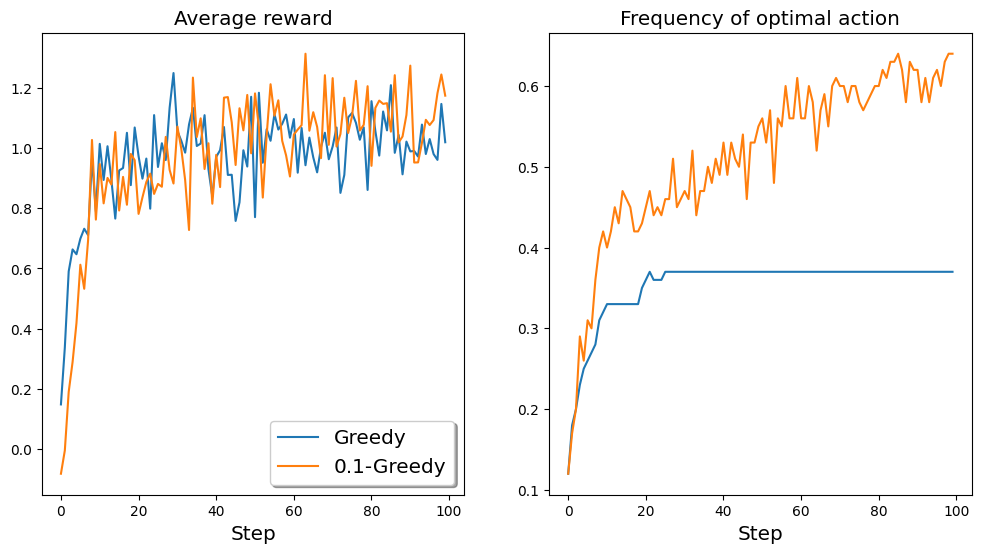

In [72]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg[:, 0], label="Greedy")
plt.plot(reward_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg[:, 0], label="Greedy")
plt.plot(optimal_avg[:, 1], label="0.1-Greedy")
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

In this third lesson, we are going to implement the learning methodologies of previous lessons in a non-stationary case. That is, rewards can change over time. Non-stationarity is the case most commonly encountered in reinforcement learning in general and finance in particular. Reinforcement learning involves a trade-off between exploration and exploitation.

We are going to fix an $\epsilon$-greedy policy that uses $\varepsilon=0.1$. Then, we are going to compare the performance of the updating policy that averages across the past history of rewards and the updating policy that uses a fixed parameter $\alpha=0.05$.

As in the application of Lesson 2, we compare the performance of both methods using the average reward by time step and the average frequency that the agent takes the optimal choice, also by each time step.

In [73]:
# LOAD LIBRARIES, PARAMETERS AND FUNCTIONS FROM LESSON 2

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, seed

# EXAMPLE OF A STATIONARY k-BANDIT PROBLEM
# Parameters
NK = 10
ITEMAX = 1000
EPSILON_M = [0.0, 0.1]
NEPISODES = 1000

seed(1234)

# Initialize actual distribution of each bandit
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=NK)

print(NMEANS)


def optimal_action(qvalue, eps):
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:
                break
    elif action_hat[0].shape[0] > 1:
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):
            if randnum < (aa + 1) / action_hat[0].shape[0]:
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


In [74]:
# EXAMPLE OF A NON-STATIONARY k-BANDIT PROBLEM


EPSILON = 0.1
ALPHA = 0.95

seed(1234)

reward_avg = np.zeros((ITEMAX, 2))
optimal_avg = np.zeros((ITEMAX, 2))

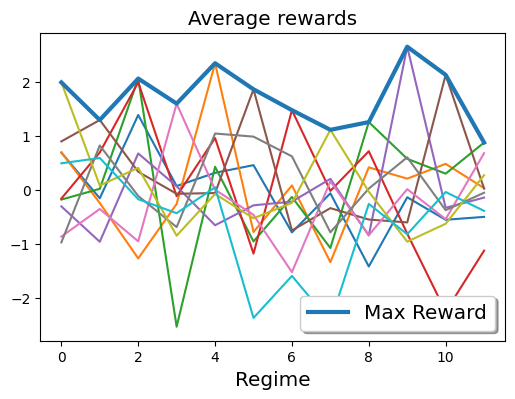

In [75]:
# Determine steps where the regime changes
PCHANGE = 0.01
tchanges = np.zeros(())
ntchanges = 0
for tt in range(ITEMAX):
    if rand() < PCHANGE:
        tchanges = np.append(tchanges, tt)
        ntchanges = ntchanges + 1

# Initialize actual distribution of each bandit across each regime change
# including the initial distribution
NMEANS = np.random.normal(loc=0.0, scale=1.0, size=(NK, ntchanges + 1))

# Plot the resulting mean rewards
for nn in range(NK):
    plt.plot(NMEANS[nn, :])

plt.plot(np.max(NMEANS, axis=0), linewidth=3.0, label="Max Reward")
legend = plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel("Regime", fontsize="x-large")
plt.title("Average rewards", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.show()

In [ ]:
# We loop over two updating procedures: 1) averaging and 2) fixed alpha
for update in range(2):
    for run in range(NEPISODES):
        # Initialize q function and actions record
        qvalue = np.zeros((NK))
        nchoices = np.zeros((NK))
        change = 0
        for tt in range(ITEMAX):
            if tchanges[change] == tt:
                nmeans0 = NMEANS[:, change]
                change = min(change + 1, ntchanges)
            aa_opt = optimal_action(qvalue, EPSILON)
            reward = np.random.normal(loc=nmeans0[aa_opt], scale=1.0)
            nchoices[aa_opt] += 1
            alpha_update = 1 / nchoices[aa_opt] * (update == 0) + ALPHA * (update == 1)
            qvalue = reward_update(aa_opt, reward, qvalue, alpha_update)
            reward_avg[tt, update] += reward / NEPISODES
            optimal_avg[tt, update] += (aa_opt == np.argmax(nmeans0)) / NEPISODES

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(reward_avg[:, 0], label="Avg. Updating")
plt.plot(reward_avg[:, 1], label="alpha-Updating")
plt.axis([-50, 1050, -1.6, 2.25])
plt.xlabel("Step", fontsize="x-large")
plt.title("Average reward", fontsize="x-large")
legend = plt.legend(loc="lower right", shadow=True, fontsize="x-large")
plt.subplot(1, 2, 2)
plt.plot(optimal_avg[:, 0])
plt.plot(optimal_avg[:, 1])
plt.xlabel("Step", fontsize="x-large")
plt.title("Frequency of optimal action", fontsize="x-large")
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

## **1. Fine-Tuning Techniques**

### **1.1 Optimistic Initial Values**

Initial action values can also be used as fine-tuning tool to encourage the exploration of actions. Rather than setting the initial action values to zero, we can set them to wildly optimistic values relative to our prior beliefs on the rewards. This optimism encourages the use of action-value methods to explore across the space of actions. While this may be of help in the stationary case, any method that focuses on the initial conditions is unlikely to help with the general nonstationary case.

### **1.2 Upper-Confidence Bound**

We need to induce some degree of exploration in the actions because we are always uncertain about our action-value estimates. The greedy actions are the currently optimal ones from a backward-looking perspective, but some of the other actions may be better without us actually knowing. However, $\varepsilon$-greedy action selection forces the non-greedy actions to be tried, but without a particular preference.

To overcome this, and prioritize the exploration of actions that we are more uncertain about, we can  follow the next optimal choice:
$$
\begin{equation}
A_t = \arg\underset{a}{\max} \left\{Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right\}
\end{equation}
$$
where the new term adjusts for the degree of "unexploration" of the action relative to the steps completed. The parameter $c>0$ controls the degree of exploration. If $N_t(a)=0$, $a$ is considered to be a maximizing action to avoid the ratio to be infinite. We will implement this procedure in the application to stock-picking strategies below.

### **1.3 Stochastic Gradient Ascent**

The methods above estimate action values and use those estimates to select actions deterministically. We can also opt for a stochastic selection. We consider learning a score or preference for each action a, which we denote $Y_t(a)$. The larger the score, the more often that action is taken, but the preference has no interpretation in terms of reward. Only the relative preference of one action over the others is important. The probabilities of taking each action arises from a soft-max distribution:
$$
\begin{equation}
\pi_t(a) = \frac{\exp(Y_t(a))}{\sum_{b\in\mathcal{A}}\exp(Y_t(b))}
\end{equation}
$$
Initially, all action preferences are the same (e.g., $Y_0(a) = 0$, for all $a$) so that all actions have an equal probability of being selected.

There is a natural learning algorithm for this setting based on the idea of stochastic gradient ascent. On each step, after selecting action $a_t$ and receiving the reward $r_t$, the action preferences are updated by:
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) + \alpha (r_t - \overline{r}_t) (1-\pi_t(a))\ if\ a=a_t
\end{equation}
$$
$$
\begin{equation}
Y_{t+1}(a) = Y_{t}(a) - \alpha (r_t - \overline{r}_t)\pi_t(a)\ if\ a\neq a_t
\end{equation}
$$
where $\alpha > 0$ is a step-size parameter as introduced above, and $\overline{r}_t$ is the average of all the rewards up through and including time t.

This method embeds the $\varepsilon$-greedy action choice allowing for time-varying probability of action selection according to past experience. However, stochastic gradient descent is prone to generate similar issues as averaging in the case of non-stationary data. This issue arises because the choice of action depends on the estimated scores, which are less sensitive to changes in the rewards of the actions after the agent has gone through decisions in many time steps.

## **2. A Stock-Picking Problem**

As an investor, you face the problem of picking one stock among a pre-selection of 5 stocks. Every day, you are going to purchase shares of a given stock and hold it for one trading day. Suppose that you have unlimited funding or at least enough to make any of the required trades in this exercise.

You are going to consider this situation as a 5-bandit problem, where we want to learn which stock yields on average the greatest profit over the holding period. Notice that a stock-picking problem is a non-stationary problem by nature, since investors' expectations and sentiment about particular stocks change over time. Moreover, contrary to the examples from previous lessons, we have lost control of the data-generation process; it is a given to us.

We first load the data and some additional libraries.

In [ ]:
# Read stock price information

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import rand, seed
import yfinance as yf


def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new


tickers = ["AAPL", "AMZN", "MSFT", "NVDA", "X"]
stock = 0
for tick in tickers:  # noQA E203
    # Read data
    PData = yf.download(tick,"2017-07-22","2022-07-27")
    #PData = pd.read_csv(tick + ".csv")
    if stock == 0:  # noQA E203
        df0 = PData[["Adj Close"]]
    else:
        df0 = pd.concat([df0, PData[["Adj Close"]]], axis=1)
    stock += 1
YData = df0.to_numpy()
YData_dates = pd.to_datetime(PData.index, format="%Y-%m-%d")

In [ ]:
PData.index


In [ ]:
print(
    "The sample period covers {:%d %b %Y} to {:%d %b %Y}".format(
        YData_dates[0], YData_dates[YData_dates.shape[0] - 1]
    )
)

plt.plot(PData.index, YData / YData[0, :])  # noQA E203
plt.legend(tickers)

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

In [ ]:
# Bandit problem for stock selection

NK = 5
EPSILON = 0.1
ALPHA = 0.1
NEPISODES = 1000
HOLD = 1
TMAX = YData.shape[0] - HOLD

seed(1234)

reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))

reward_queue = np.zeros((HOLD, 2))

for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, EPSILON)
        nactions[aa_opt] += 1
        # Compute reward as return over holding period
        reward_queue[HOLD - 1, 0] = (
            YData[tt + HOLD, aa_opt] - YData[tt, aa_opt]
        ) / YData[tt, aa_opt]
        reward_queue[HOLD - 1, 1] = aa_opt
        # Update Q function using action chosen HOLD days before
        qvalue = reward_update(
            int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
        )
        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK):
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
        reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
        optimal_avg[tt] += (
            aa_opt == np.argmax((YData[tt + HOLD, :] - YData[tt, :]) / YData[tt, :])
        ) / NEPISODES  # noQA E203

Now we run the $k$-armed bandit algorithm as in the previous examples of this module. As it becomes clear below, the non-stationary nature of the data calls for less exploration and quick adjustment to new data. Thus, we choose parameters $\varepsilon=0.1$ and $\alpha=0.975$.

In every time step, we update the action-value function, while the actual stock picked depends also on its lack of exploration. The code is general enough to allow for holding periods longer than one day. For this, we need to maintain a record of the past history of choices and rewards. We make trading decisions, but rewards of the actions are only known at some later period rather than immediately.

In [ ]:
plt.plot(YData_dates[HOLD : YData.shape[0]], optimal_avg)  # noQA E203
plt.title("Frequency of optimal action", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

In [ ]:
plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :],
)  # noQA E203
plt.legend(tickers)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.max(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.mean(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print(np.mean(optimal_avg))
# Average annualized return from holding the equally-weighted portfolio
print(
    (
        1
        + np.mean(
            (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :],
            axis=1,
        )
    ),
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print(
    (1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,
    np.sqrt(250 / HOLD) * np.std(reward_avg),
)

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (YData[tt + HOLD - 1, :] - YData[tt - 1, :]) / YData[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()